In [18]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [21]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5","exams_part12.hdf5", "exams_part13.hdf5", "exams_part10.hdf5", "exams_part11.hdf5","exams_part9.hdf5", "exams_part8.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == True) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == True) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

ecg_doente = ecg_doente_id[:3000]
ecg_normal = ecg_normal_id[:8000]

ids_ecgs = ecg_doente + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 73700
Número de linhas ecg_doente_linhas: 3809
Tirando Interferência:
Número de linhas ecg_normal_linhas: 71713
Número de linhas ecg_doente_linhas: 3748
Número de ecgs pra clusterizar: 11000


In [22]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5']



# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    #Selecionar as leads V1 (índice 6) e V6 (índice 11)
    #lead_v1 = tracings[:, 6]
    #lead_v6 = tracings[:, 11]
    lead_d2 = tracings[:, 1]
    #Combinar as leads V1 e V6 em uma única dimensão
    #combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(lead_d2)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)
# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (11000, 4096)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=40, kernel_size=16, stride=2, padding=7)
        self.bn1 = nn.BatchNorm1d(40)
        
        self.conv2 = nn.Conv1d(in_channels=40, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.bn2 = nn.BatchNorm1d(20)
        
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.bn3 = nn.BatchNorm1d(20)
        
        self.conv4 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.bn4 = nn.BatchNorm1d(20)
        
        self.conv5 = nn.Conv1d(in_channels=20, out_channels=40, kernel_size=16, stride=2, padding=7)
        self.bn5 = nn.BatchNorm1d(40)
        
        self.conv6 = nn.Conv1d(in_channels=40, out_channels=1, kernel_size=16, stride=1, padding=7)
        self.bn6 = nn.BatchNorm1d(1)

    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))
        x = F.elu(self.bn4(self.conv4(x)))
        x = F.elu(self.bn5(self.conv5(x)))
        x = self.bn6(self.conv6(x))  # Sem função de ativação na última camada
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(in_channels=1, out_channels=40, kernel_size=16, stride=1, padding=7)
        self.bn1 = nn.BatchNorm1d(40)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=40, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn2 = nn.BatchNorm1d(20)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn3 = nn.BatchNorm1d(20)
        
        self.deconv4 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn4 = nn.BatchNorm1d(20)
        
        self.deconv5 = nn.ConvTranspose1d(in_channels=20, out_channels=40, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.bn5 = nn.BatchNorm1d(40)
        
        self.deconv6 = nn.ConvTranspose1d(in_channels=40, out_channels=1, kernel_size=16, stride=2, padding=7, output_padding=0)

    def forward(self, x):
        x = F.elu(self.bn1(self.deconv1(x)))
        x = F.elu(self.bn2(self.deconv2(x)))
        x = F.elu(self.bn3(self.deconv3(x)))
        x = F.elu(self.bn4(self.deconv4(x)))
        x = F.elu(self.bn5(self.deconv5(x)))
        x = self.deconv6(x)  # Sem função de ativação na última camada
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

 

In [24]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)


 #Carregar os pesos salvos
 

    
autoencoder = Autoencoder()   
model_path = 'best_autoencoder.pth'
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()  # Colocar o modelo em modo de avaliação

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.encoder

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Converter os dados para um tensor PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)

# Obter os vetores codificados para todo o conjunto X
with torch.no_grad():
    X_encoded = encoder(X_tensor).numpy()

print("Forma da saída do encoder antes de remover a dimensão extra:", X_encoded.shape)

if X_encoded.shape[1] == 1:
    X_encoded_2d = X_encoded.squeeze(1)


# Verificar a forma final
print("Forma final da saída do encoder:", X_encoded_2d.shape)  # Deve ser (13748, 128)

/tmp/ipykernel_305028/652341233.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(model_path))


Forma da saída do encoder antes de remover a dimensão extra: (11000, 1, 127)
Forma final da saída do encoder: (11000, 127)


In [31]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=20, min_dist=0.05, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

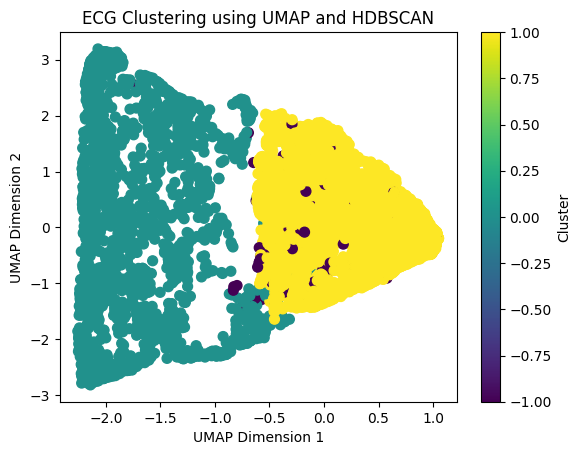

Silhouette Score: -0.043359801173210144
   cluster  1dAVb  RBBB  LBBB  SB    ST  AF  normal_ecg
0       -1      0     0     0   0    71   0          78
1        0      0     0     0   0  2269   0          96
2        1      0     0     0   0   660   0        7826


In [32]:
#CLUSTERIZACAO HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=1000, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')


# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': ids_ecgs,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)